In [1]:
using CSV
using DataFrames
using Plots
using LinearAlgebra

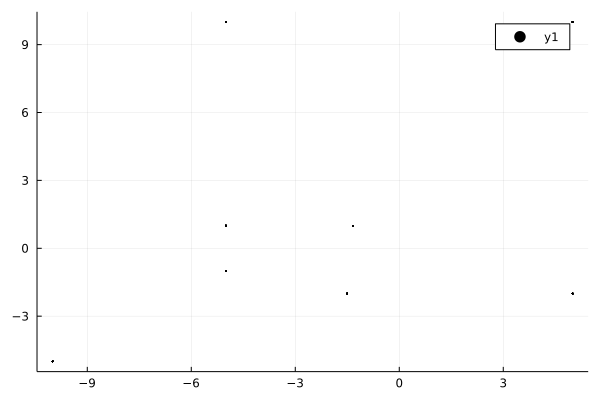

In [2]:
dubinsData = CSV.read("dubinsOutCirc.csv", DataFrame)
size(dubinsData)
length(dubinsData.x)
display(scatter(dubinsData.x_final, dubinsData.y_final, markersize = 1, color = :black, msc=:black, markershape = :circle))

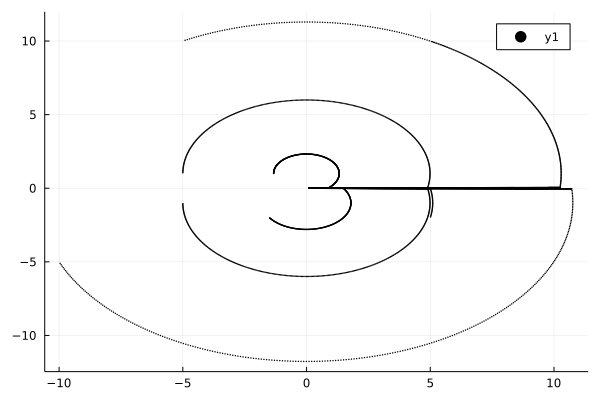

In [3]:
data = deepcopy(dubinsData)

round.(data.u)

function shift_rotate(x, y, x_shift, y_shift, θ_shift)
    v = [x - x_shift, y-y_shift]
    R = [cos(θ_shift) sin(θ_shift); -sin(θ_shift) cos(θ_shift)]
    vf = R*v
    return vf[1], vf[2]
end

tempX = zeros(length(data.x_final))
tempY = zeros(length(data.y_final))

for i=1:length(data.x_final)
    (tempX[i], tempY[i]) = shift_rotate(data.x_final[i], data.y_final[i],
                                                      data.x[i], data.y[i], data.theta[i])
end

data.x_final .= tempX
data.y_final .= tempY

data.x .= 0
data.y .= 0
data.theta .= 0
scatter(data.x_final, data.y_final, markersize = 1, color = :black, msc=:black, markershape = :circle)

In [4]:
# Remove most of the data on x-axis to make the dataset balanced
cond1 = (data.y_final .<= -0.05) .| (data.y_final .>= 0.05)  # Keep this data which is away from x-axis
cond2 = (collect(1:length(data.y_final))) .% 2000 .== 0  # Keep this data which is index less than 2000
cond3 = (data.u .!= 0) # Keep the data only if input is nonzero
dataX = data[(cond1 .| cond2) .& cond3,:]
scatter(dataX.x_final, dataX.y_final, markersize = 1, color = :black, msc=:black, markershape = :circle)
dataX[!,:input] .= Int64.(round.(dataX.u))
select!(dataX, [:x_final, :y_final, :input])
dataN = dataX[(dataX.input .!= 0),:]

,x_final,y_final,input
,Float64,Float64,Int64
1,-1.3301,0.996851,1
2,-1.33006,1.0101,1
3,-1.3299,1.02335,1
4,-1.3296,1.0366,1
5,-1.32916,1.04984,1
6,-1.3286,1.06308,1
7,-1.3279,1.07631,1
8,-1.32707,1.08954,1
9,-1.32611,1.10276,1


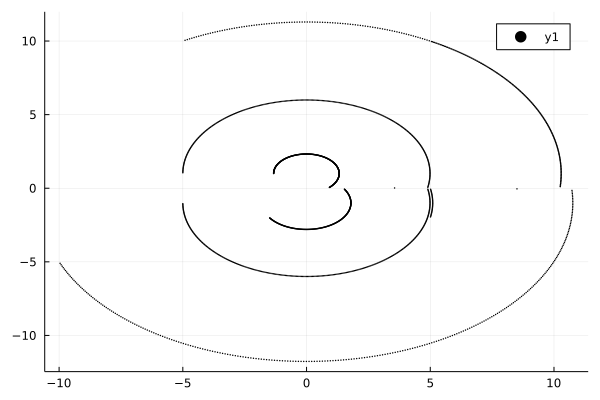

In [5]:
X = [dataN.x_final dataN.y_final]
y = dataN.input
scatter(dataN.x_final, dataN.y_final, markersize = 1, color = :black, msc=:black, markershape = :circle)

In [6]:
using ScikitLearn
using ScikitLearn.CrossValidation: train_test_split
@sk_import tree: DecisionTreeClassifier
@sk_import preprocessing: StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

4-element Vector{Array}:
 [7.981253816786341 7.501524176314253; 1.9824126199096619 -5.582590937622611; … ; 1.5837104669902873 -0.15675936245699962; 8.646712872773017 6.5855121766333005]
 [9.016192038469127 5.966707805650527; 1.271076419179554 -2.267536789785591; … ; 1.722555916474561 -1.5005835385580444; -0.4852455628765963 11.281992405791868]
 [1, -1, -1, -1, 1, 1, 1, 1, -1, -1  …  -1, -1, -1, 1, -1, -1, 1, 1, -1, 1]
 [1, -1, 1, -1, 1, -1, -1, 1, -1, -1  …  -1, 1, -1, -1, -1, -1, -1, -1, -1, 1]

In [7]:
DTClassifier = DecisionTreeClassifier(max_depth =100,criterion="entropy")
dTree = DTClassifier.fit(X_train, y_train)
y_pred = dTree.predict(X_test)
dTree.predict([1 2])

1-element Vector{Int64}:
 1

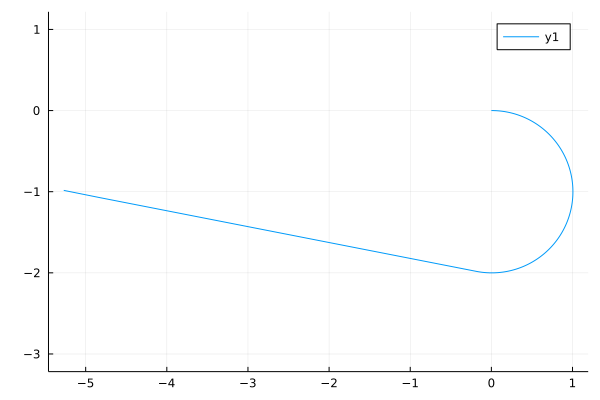

In [8]:
# Simulation using the learned model
dubins_dyn(x, u) = [cos(x[3]), sin(x[3]), u]
x0 = [0, 0, 0]
xf = [-5.368, -1]
n_iter = 1000
dt = 0.01

states = zeros(n_iter, 3)
input = zeros(n_iter)

states[1,:] .= x0
last_ind = 1
dubins_dyn(x0, 1)*dt
for i=1:n_iter-1
    x_tran = shift_rotate(xf[1], xf[2], states[i,1], states[i,2], states[i, 3])
    u = dTree.predict([x_tran[1] x_tran[2]])
    states[i+1,:] .= states[i,:] .+ dt*dubins_dyn(states[i,:], u[1])
    last_ind = i
    if norm(xf-states[i,1:2]) < 0.1
        break
    end
end

plot(states[1:last_ind,1], states[1:last_ind,2], aspect_ratio = 1)

In [9]:
?reshape

search: reshape promote_shape



```
reshape(A, dims...) -> AbstractArray
reshape(A, dims) -> AbstractArray
```

Return an array with the same data as `A`, but with different dimension sizes or number of dimensions. The two arrays share the same underlying data, so that the result is mutable if and only if `A` is mutable, and setting elements of one alters the values of the other.

The new dimensions may be specified either as a list of arguments or as a shape tuple. At most one dimension may be specified with a `:`, in which case its length is computed such that its product with all the specified dimensions is equal to the length of the original array `A`. The total number of elements must not change.

# Examples

```jldoctest
julia> A = Vector(1:16)
16-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16

julia> reshape(A, (4, 4))
4×4 Matrix{Int64}:
 1  5   9  13
 2  6  10  14
 3  7  11  15
 4  8  12  16

julia> reshape(A, 2, :)
2×8 Matrix{Int64}:
 1  3  5  7   9  11  13  15
 2  4  6  8  10  12  14  16

julia> reshape(1:6, 2, 3)
2×3 reshape(::UnitRange{Int64}, 2, 3) with eltype Int64:
 1  3  5
 2  4  6
```
